# vvm_precip.ipynb

- This notebook reproduces the following rainfall figures (with TaiwanVVM simulation) in Guo et al. (2025).
    - Fig. 5
    - Fig. 6(c)(f)
    - Supplementary figures S9
- **Additional data reminder**:
    - TaiwanVVM simulation data are available from the corresponding author upon reasonable request.
- Execution order of cell sections for reproducing figures: 
    1. `Import`
    2. `Utilities`
    3. Each `Figure: ...`

# Import

In [24]:
import numpy as np
import pandas as pd
from datetime import *
from vvmtools.analyze import DataRetriever
# --- self define modules --- #
import importlib
import sys
sys.path.append('../../src/taiwanvvm/')
import PlotTools
importlib.reload(PlotTools)

<module 'PlotTools' from '/data/ch995334/Multiscale-MoistDyn-Control/notebooks/taiwanvvm/../../src/taiwanvvm/PlotTools.py'>

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import seaborn.colors.xkcd_rgb as c
from matplotlib.gridspec import GridSpec

## Common instances

# Utilities

## Data

In [4]:
wtab_all = pd.read_csv('../../data/processed/weather_table_self/all_withlv.csv')

## !!

In [44]:
taiwanvvm_fpath = ''

## Simulation dates

In [7]:
dlist_atsim40 = ['20050702', '20050712', '20050723', '20050826',
                 '20060508', '20060623', '20060702', '20060718', '20060721',
                 '20070830', 
                 '20080715',
                 '20090707', '20090817', '20090827',
                 '20100629', '20100630', '20100802', '20100803', '20100912',
                 '20110615', '20110616', '20110702', '20110723', '20110802', '20110816', '20110821',
                 '20120715', '20120819',
                 '20130630', '20130703', '20130705', '20130723', '20130807', '20130825', 
                 '20140525', '20140703', '20140711', '20140714', '20140825', 
                 '20150613']

In [8]:
dobj_atsim40  = pd.to_datetime(dlist_atsim40, format='%Y%m%d')
wtab_all['yyyymmdd'] = pd.to_datetime(wtab_all['yyyymmdd'], format='%Y%m%d')
wtab_atsim40  = wtab_all[wtab_all['yyyymmdd'].isin(dobj_atsim40)]
wtab_atsim_6reg = wtab_atsim40[(wtab_atsim40['ERA5_all_lv0']>=-4)&\
                               (wtab_atsim40['ERA5_all_lv0']<2)&\
                               (wtab_atsim40['ERA5_all_lv1']>=-4)&\
                               (wtab_atsim40['ERA5_all_lv1']<0)]
dlist_atsim_6reg = [datetime.strftime(i, format='%Y%m%d') for i in wtab_atsim_6reg['yyyymmdd']]
len(dlist_atsim_6reg)

33

In [9]:
dlist_swsim = ['20140810', '20140813',
               '20150522', '20150524', '20150719', '20150720', '20150809', '20150828', '20150829', 
               '20160610', '20160611', '20160711', '20160712', '20160902',
               '20170602', '20170614', '20170615', '20170731',
               '20180617', '20180618', '20180619', '20180620', '20180701', '20180702', '20180815', '20180828',
               '20190611', '20190710', '20190810', '20190815']

In [10]:
len(dlist_swsim)

30

## Plot tools for VVM

In [26]:
plottools     = PlotTools.PlotTools_vvm()

## Function: Calculate daily precip. from TaiwanVVM

In [21]:
def cal_vvm_dpcp(case:str, date:str, swsuffix:str='', domain_range:tuple=(None, None, None, None), land_only:bool=True):
    # Check
    print(f"Calculating daily precipitation. The Land-only option is now: {land_only}.")
    # Calculation
    j1, j2, i1, i2 = domain_range
    if case == 'sw':
        vvmtools_date  = DataRetriever(f"{taiwanvvm_fpath}/taiwanvvm_sw/case_sw_{date}{swsuffix}")
    elif case == 'at':
        vvmtools_date  = DataRetriever(f"{taiwanvvm_fpath}/taiwanvvm_at/tpe{date}nor")
    else:
        raise ValueError("Argument `case` should be either 'sw' or 'at'.")
    arr_pcp_all    = vvmtools_date.get_var_parallel(var='sprec', time_steps=np.arange(145))
    arr_day_pcp    = np.sum(arr_pcp_all, axis=0)*3600/6
    if land_only:
        arr_day_pcp = np.where(plottools.ds_topo.TOPO>0, arr_day_pcp, np.nan)
    return arr_day_pcp[j1:j2, i1:i2]

# Figure: TaiwanVVM daily precip.

## Individual days

In [13]:
def Plot_vvm_dpcp(case:str, date:str, swsuffix:str='', cbar=True, topo_contour_lw=0.5, pcp_on_top=False, regional_rect=False, land_only:bool=False, figtitle=False):
    # Data initialize
    arr_day_pcp = cal_vvm_dpcp(case=case, date=date, swsuffix=swsuffix, land_only=land_only)
    # Figure initialize
    fig = plt.figure(figsize=(4, 8))
    gs  = GridSpec(1, 1, figure=fig)
    bounds = np.array([1, 2, 6, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 300])
    # ----------------------------------------------------------------------------------------
    # Plot
    ax1   = plottools.Axe_map(fig, gs[0], xlim_=[119.95, 122.05], ylim_=[21.85, 25.5],
                                    xloc_=np.arange(120, 122.1, 1), yloc_=np.arange(22, 25.1, 1))
    plottools.Plot_vvm_map(ax1, c['dark grey'], 1.5)  # coastline
    ## precip.
    imvvm = plottools.Plot_vvm_pcp(ax1, np.where(arr_day_pcp>1, arr_day_pcp, np.nan), transform_option='map')
    if pcp_on_top:
        pcp_zorder = 20
        imvvm.set_zorder(pcp_zorder)
        imvvm.set_alpha(0.8)
    if cbar:
        cax  = fig.add_axes([ax1.get_position().x1+0.28, ax1.get_position().y0, 0.03, ax1.get_position().height])
        cbar = fig.colorbar(imvvm, orientation='vertical', cax=cax)
        cbar.solids.set(alpha=1)  # Default: set cbar to full color (w/out tranparency)
        cbar.set_ticks(ticks=bounds, labels=[int(i) for i in bounds])
        cbar.ax.tick_params(labelsize=13)
        cbar.set_label('mm/day', fontsize=16)
        cbar.outline.set_linewidth(1.5)
    ## topo
    topo_bounds= np.arange(0, 3500.1, 500)
    imtopoh    = plottools.Plot_vvm_topo(ax1, c['dark grey'], topo_contour_lw)
    if cbar:
        cax  = fig.add_axes([ax1.get_position().x1+0.04, ax1.get_position().y0, 0.03, ax1.get_position().height])
        cbar = fig.colorbar(imtopoh, orientation='vertical', cax=cax)
        cbar.set_ticks(ticks=topo_bounds, labels=[f"{i/1e3:.1f}" for i in topo_bounds])
        cbar.ax.tick_params(labelsize=13)
        cbar.set_label('Topography Height (km)', fontsize=16)
        cbar.outline.set_linewidth(1.5)
    
    ax1.set_xticklabels([f'{int(i)}\N{DEGREE SIGN} E' for i in np.arange(120, 122.1, 1)], fontsize=20) # fontsize changed from 16
    ax1.set_yticklabels([f'{int(i)}\N{DEGREE SIGN} N' for i in np.arange(22, 25.1, 1)], fontsize=20)
    if regional_rect:
        rect = patches.Rectangle((regional_rect[0], regional_rect[2]), regional_rect[1]-regional_rect[0], regional_rect[3]-regional_rect[2], 
                                 fc="none", ec=c['black'], linewidth=2, zorder=50, label='south-\nwestern')
        ax1.add_artist(rect)
        ax1.legend(handles=[rect], fontsize=13, loc='lower right')
    if figtitle:
        ax1.set_title(f'{figtitle}', loc='left', fontsize=20)
    else:
        ax1.set_title('VVM precipitation', fontsize=16)
        fig.suptitle(x=0.5, y=0.91, t=date, fontsize=18, fontweight='bold')
    plt.show()

### Fig. 5c–e

Calculating daily precipitation. The Land-only option is now: True.


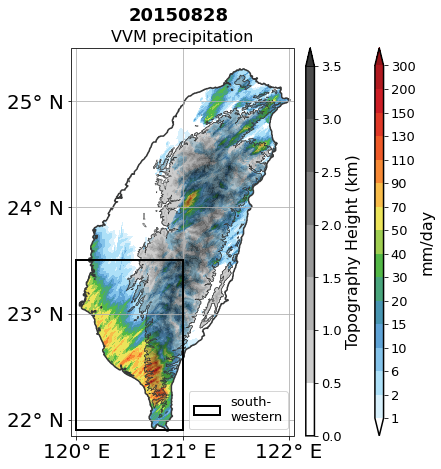

In [27]:
Plot_vvm_dpcp(case='sw', date=20150828, land_only=True, regional_rect=(120, 121, 21.9, 23.5))

Calculating daily precipitation. The Land-only option is now: True.


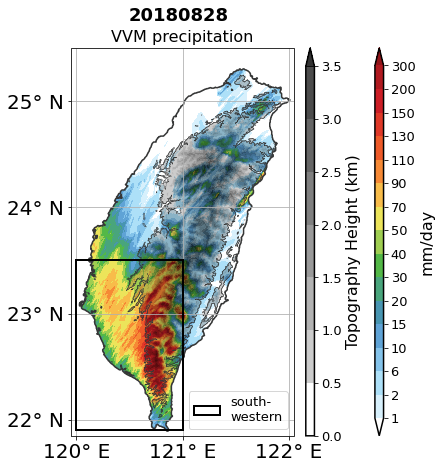

In [29]:
Plot_vvm_dpcp(case='sw', date=20180828, land_only=True, regional_rect=(120, 121, 21.9, 23.5))

Calculating daily precipitation. The Land-only option is now: True.


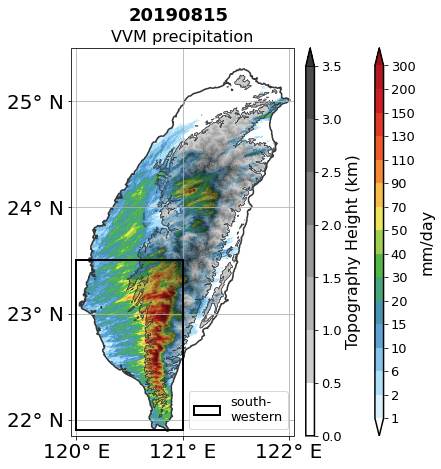

In [30]:
Plot_vvm_dpcp(case='sw', date=20190815, land_only=True, regional_rect=(120, 121, 21.9, 23.5))

### Fig. S9

Calculating daily precipitation. The Land-only option is now: True.


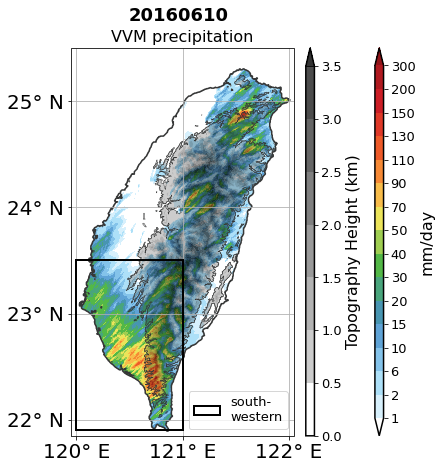

In [31]:
Plot_vvm_dpcp(case='sw', date=20160610, swsuffix='_sim6', land_only=True, regional_rect=(120, 121, 21.9, 23.5))

Calculating daily precipitation. The Land-only option is now: True.


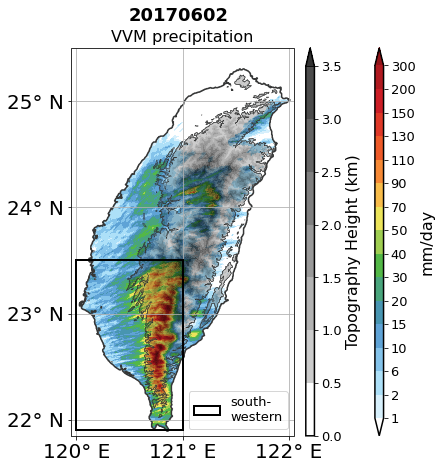

In [32]:
Plot_vvm_dpcp(case='sw', date=20170602, land_only=True, regional_rect=(120, 121, 21.9, 23.5))

Calculating daily precipitation. The Land-only option is now: True.


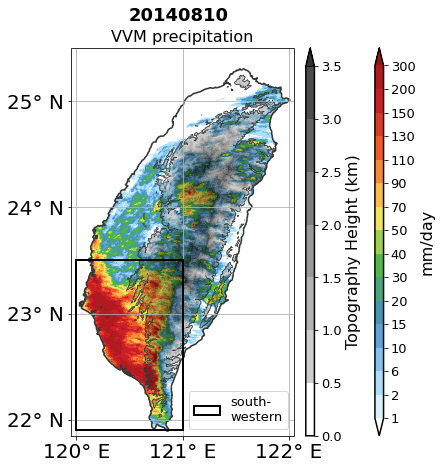

In [33]:
Plot_vvm_dpcp(case='sw', date=20140810, land_only=True, regional_rect=(120, 121, 21.9, 23.5))

### Fig. 5a–b

Calculating daily precipitation. The Land-only option is now: True.


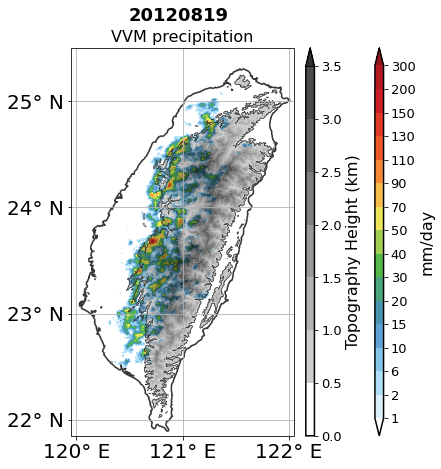

In [35]:
Plot_vvm_dpcp(case='at', date=20120819, land_only=True)

Calculating daily precipitation. The Land-only option is now: True.


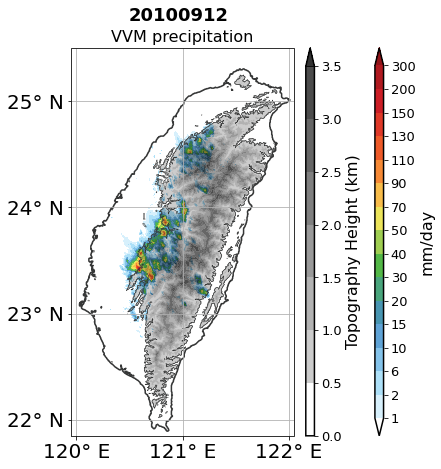

In [36]:
Plot_vvm_dpcp(case='at', date=20100912, land_only=True)

## Composite

In [39]:
def Cal_vvm_dpcp_comp(case:str, datelist:list, land_only:bool=False):
    # Check for available simulation
    if case not in ('sw', 'at'):
        raise ValueError("Argument `case` should be either 'sw' or 'at'.")
    # Calculation
    counter = 1
    for i, dd in enumerate(datelist):
        if dd == '20180815':
            dd = '20140815'  # rename date (this one is a typo)
        # Data initialize
        if i < 1:
            arr_day_pcp = cal_vvm_dpcp(case=case, date=dd, land_only=land_only)[..., np.newaxis]
        else:
            try:
                temp    = cal_vvm_dpcp(case=case, date=dd, land_only=land_only)[..., np.newaxis]
            except:
                temp    = cal_vvm_dpcp(case=case, date=dd, swsuffix=f'_sim{counter}', land_only=land_only)[..., np.newaxis]
                counter+= 1
            arr_day_pcp = np.concatenate((arr_day_pcp, temp), axis=-1)
    mean_pcp = np.nanmean(arr_day_pcp, axis=-1)
    return mean_pcp

In [37]:
def Plot_vvm_dpcp_comp(case:str, mean_pcp:np.ndarray, land_only:bool=False, figtitle=False):
    # Data initialize
    if land_only:
        mean_pcp = np.where(plottools.ds_topo.TOPO>0, mean_pcp, np.nan)
    # Figure initialize
    fig = plt.figure(figsize=(4, 8))
    gs  = GridSpec(1, 1, figure=fig)
    if case == 'sw':
        bounds    = np.array([2, 5, 10, 15, 25, 40, 50, 70, 90])
    elif case == 'at':
        bounds    = np.array([2, 5, 10, 15, 25])
    else:
        raise ValueError("Argument `case` should be either 'sw' or 'at'.")
    # ----------------------------------------------------------------------------------------
    # Plot
    ax1   = plottools.Axe_map(fig, gs[0], xlim_=[119.95, 122.05], ylim_=[21.85, 25.5],
                                    xloc_=np.arange(120, 122.1, 1), yloc_=np.arange(22, 25.1, 1))
    plottools.Plot_vvm_map(ax1, c['dark grey'], 1.5)  # coastline
    ## precip.
    imvvm = plottools.Plot_vvm_pcp(ax1, mean_pcp, bounds=bounds, transform_option='map')
    cax  = fig.add_axes([ax1.get_position().x1+0.06, ax1.get_position().y0, 0.03, ax1.get_position().height])
    cbar = fig.colorbar(imvvm, orientation='vertical', cax=cax)
    cbar.solids.set(alpha=1)  # Default: set cbar to full color (w/out tranparency)
    cbar.set_label('mm/day', fontsize=16)
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_linewidth(1.5)
    ## topo
    topo_bounds= np.arange(0, 3500.1, 500)
    imtopoh    = plottools.Plot_vvm_topo(ax1, c['dark grey'], 0.5)
    cax  = fig.add_axes([ax1.get_position().x0,ax1.get_position().y0-0.06, ax1.get_position().width, 0.015])
    cbar = fig.colorbar(imtopoh, orientation='horizontal', cax=cax, extend='max')
    cbar.set_ticks(ticks=topo_bounds, labels=[f"{i/1e3:.1f}" for i in topo_bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('Topography Height (km)', fontsize=16)
    cbar.outline.set_linewidth(1.5)
    
    ax1.set_xticklabels([f'{int(i)}\N{DEGREE SIGN} E' for i in np.arange(120, 122.1, 1)], fontsize=16)
    ax1.set_yticklabels([f'{int(i)}\N{DEGREE SIGN} N' for i in np.arange(22, 25.1, 1)], fontsize=16)
    if figtitle:
        ax1.set_title(f'{figtitle}', loc='left', fontsize=20)
    else:
        ax1.set_title('VVM precipitation', fontsize=16)
        fig.suptitle(x=0.5, y=0.91, t=f'Composite [6 Reg. {case.upper()}]', fontsize=18, fontweight='bold')
    plt.show()

### Fig. 6f

In [40]:
meanpcp_swsim_6reg = Cal_vvm_dpcp_comp(case='sw', datelist=dlist_swsim)

Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


In [64]:
meanpcp_swsim_6reg

array([[3.4432456, 3.3846436, 3.3038723, ..., 3.7210886, 3.5285234,
        3.4683158],
       [3.373523 , 3.3280063, 3.229226 , ..., 3.7367709, 3.469911 ,
        3.3527155],
       [3.2689674, 3.1931152, 3.0784981, ..., 3.7252028, 3.471493 ,
        3.289363 ],
       ...,
       [3.148914 , 3.1748357, 3.233566 , ..., 3.2050629, 3.096786 ,
        3.0652635],
       [3.1704981, 3.2256045, 3.273735 , ..., 3.5090454, 3.3216395,
        3.1599307],
       [3.3033345, 3.286215 , 3.2742925, ..., 3.6771953, 3.5168948,
        3.38177  ]], dtype=float32)

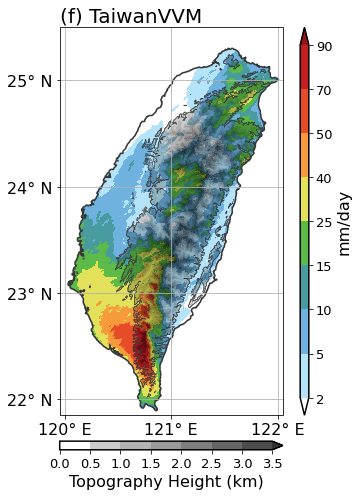

In [41]:
Plot_vvm_dpcp_comp(case='sw', mean_pcp=meanpcp_swsim_6reg, land_only=True, figtitle='(f) TaiwanVVM')

### Fig. 6c

In [42]:
meanpcp_atsim_6reg = Cal_vvm_dpcp_comp(case='at', datelist=dlist_atsim_6reg)

Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.
Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


Calculating daily precipitation. The Land-only option is now: False.


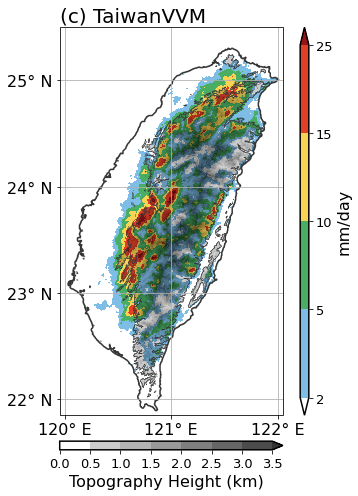

In [43]:
Plot_vvm_dpcp_comp(case='at', mean_pcp=meanpcp_atsim_6reg, land_only=True, figtitle='(c) TaiwanVVM')